In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch
from torchvision import transforms
from face_alignment import align
from backbones import get_model
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
torch.cuda.is_available()

True

In [ ]:

from sklearn.metrics import accuracy_score

e:\synclabs\edgeface\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import os

In [5]:
# load model
model_name="edgeface_xs_gamma_06" # or edgeface_xs_gamma_06
model=get_model(model_name)
checkpoint_path=f'checkpoints/{model_name}.pt'
model.load_state_dict(torch.load(checkpoint_path, map_location='cuda'))

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ])

C:\Users\rajni\AppData\Local\Temp\ipykernel_20040\3159899112.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locati

In [15]:
from PIL import Image
img = Image.open("new_test/rajnish1.JPG")
img.save("new_test/rajnish1_fixed.JPG") 

In [20]:
img1_path = r"new_test\rajnish1_new.JPG"
img2_path =  r"new_test\rajnish1_cropped.JPG"

In [23]:
aligned = align.get_aligned_face(img1_path) # align face
transformed_input1 = transform(aligned)
aligned = align.get_aligned_face(img2_path) # align face
transformed_input2 = transform(aligned)

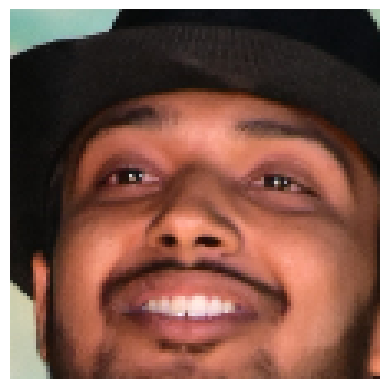

In [24]:
# Convert the tensor to a numpy array and transpose to (H, W, C) for imshow
img_np = transformed_input2.permute(1, 2, 0).cpu().numpy()
# Undo normalization for display: x = x * std + mean
img_np = (img_np * 0.5) + 0.5
img_np = np.clip(img_np, 0, 1)
plt.imshow(img_np)
plt.axis('off')
plt.show()

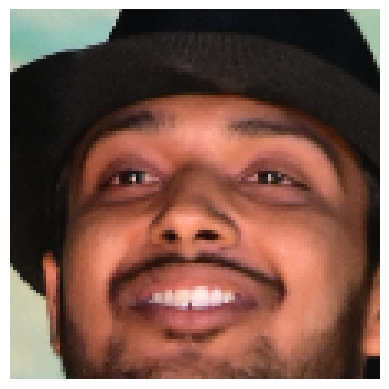

In [25]:
# Convert the tensor to a numpy array and transpose to (H, W, C) for imshow
img_np = transformed_input1.permute(1, 2, 0).cpu().numpy()
# Undo normalization for display: x = x * std + mean
img_np = (img_np * 0.5) + 0.5
img_np = np.clip(img_np, 0, 1)
plt.imshow(img_np)
plt.axis('off')
plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [113]:
def read_face_pairs(file_path):
    pairs = []
    labels = []
    
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) == 3:
                # Same person, positive pair (1)
                person, idx1, idx2 = parts
                idx1 = int(idx1)
                idx2 = int(idx2)
                pairs.append((f"{person}_{idx1:04d}", f"{person}_{idx2:04d}"))
                labels.append(1)
            elif len(parts) == 4:
                # Different people, negative pair (0)
                person1, idx1, person2, idx2 = parts
                idx1 = int(idx1)
                idx2 = int(idx2)
                pairs.append((f"{person1}_{idx1:04d}", f"{person2}_{idx2:04d}"))
                labels.append(0)
    
    return pairs, labels

# Function to load an image given the person and index
def load_image(person, idx, lfw_funneled_dir):
    image_path = os.path.join(lfw_funneled_dir, person, f"{person}_{int(idx):04d}.jpg")
    if os.path.exists(image_path):
        # Return the path if the image exists
        return image_path
    else:
        raise FileNotFoundError(f"Image not found: {image_path}")

In [116]:
# Convert the image path into an actual image and preprocess it
def get_embeddings(image_path):
    try:
        # Load the image using PIL (or OpenCV)
     
        aligned = align.get_aligned_face(image_path)  # Assuming `align.get_aligned_face` works with PIL image
        transformed_input = transform(aligned)  # Apply the necessary transformations (e.g., normalization)
        transformed_input = transformed_input.unsqueeze(0)  # Add batch dimension
        transformed_input = transformed_input.to(device)  
        embedding = model(transformed_input)  # Get the embedding from your model
        return embedding
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None  # Return None if there's any issue

# Calculate cosine similarity using PyTorch's built-in function
def get_similarity(embedding1, embedding2):
    # Ensure embeddings are on CPU for cosine similarity
    embedding1 = embedding1.cpu()
    embedding2 = embedding2.cpu()
    
    # Normalize the embeddings (unit vectors) before calculating cosine similarity
    similarity = torch.nn.functional.cosine_similarity(embedding1, embedding2)
    return similarity.item()

# Function to evaluate the LFW dataset using pairs
def evaluate_lfw(pair_file_path, lfw_funneled_dir, device, threshold=0.5):
    pairs, labels = read_face_pairs(pair_file_path)
    predictions = []
    skipped = 0  # Count how many pairs are skipped
    
    for (image1, image2), label in zip(pairs, labels):
        # Extract person names and indices from image identifiers
        person1, idx1 = image1.rsplit('_', 1)
        person2, idx2 = image2.rsplit('_', 1)
        
        try:
            # Load and generate embeddings for the two images
            image1_path = load_image(person1, int(idx1), lfw_funneled_dir)
            image2_path = load_image(person2, int(idx2), lfw_funneled_dir)
            
            if image1_path is None or image2_path is None:
                skipped += 1
                continue  # Skip this pair if image loading fails
            
            embedding1 = get_embeddings(image1_path)
            embedding2 = get_embeddings(image2_path)
            
            # Skip if either embedding is None (indicating an error)
            if embedding1 is None or embedding2 is None:
                skipped += 1
                continue  # Skip this pair and move to the next one
            
            # Compute similarity
            similarity = get_similarity(embedding1, embedding2)
            predicted_label = 1 if similarity > threshold else 0
            # print(f"Pair: {image1} vs {image2}, Similarity: {similarity:.4f}, Predicted: {predicted_label}, Actual: {label}")
            predictions.append(predicted_label)
        
        except FileNotFoundError as e:
            print(e)
            skipped += 1
            continue  # Skip this pair if any image is not found
        
        except Exception as e:
            print(f"Error processing pair {image1} vs {image2}: {e}")
            skipped += 1
            continue  # Skip this pair on any other error
    
    # Calculate accuracy
    accuracy = accuracy_score(labels[:len(predictions)], predictions)  # Slice labels to match predictions
    print(f"Accuracy: {accuracy * 100:.2f}%, Skipped pairs: {skipped}")
    return accuracy

In [117]:
pair_file = r"LFW\pairsDevTest.txt"
lfw_funneled_dir = r"LFW\lfw_funneled"

In [118]:
accuracy = evaluate_lfw(pair_file, lfw_funneled_dir, device, threshold=0.5)

Face detection Failed due to error.
list index out of range
Error processing LFW\lfw_funneled\Daisy_Fuentes\Daisy_Fuentes_0003.jpg: pic should be PIL Image or ndarray. Got <class 'NoneType'>
Face detection Failed due to error.
list index out of range
Error processing LFW\lfw_funneled\John_Stallworth\John_Stallworth_0002.jpg: pic should be PIL Image or ndarray. Got <class 'NoneType'>
Face detection Failed due to error.
list index out of range
Error processing LFW\lfw_funneled\Luis_Horna\Luis_Horna_0002.jpg: pic should be PIL Image or ndarray. Got <class 'NoneType'>
Face detection Failed due to error.
list index out of range
Error processing LFW\lfw_funneled\Tyler_Hamilton\Tyler_Hamilton_0002.jpg: pic should be PIL Image or ndarray. Got <class 'NoneType'>
Face detection Failed due to error.
list index out of range
Error processing LFW\lfw_funneled\Warren_Buffett\Warren_Buffett_0001.jpg: pic should be PIL Image or ndarray. Got <class 'NoneType'>
Face detection Failed due to error.
list in

In [120]:
import tensorflow as tf
import os

# Load TFLite model
tflite_model_path = "../IoT/Models/person_identification/facenetv2.tflite"
with open(tflite_model_path, "rb") as f:
    tflite_model = f.read()

# Check model size in bytes and MB
tflite_model_size = os.path.getsize(tflite_model_path)
print(f"TFLite model size: {tflite_model_size} bytes ({tflite_model_size / (1024 * 1024):.2f} MB)")

TFLite model size: 94059852 bytes (89.70 MB)


In [121]:
# Calculate and print the size of the PyTorch model in MB
torch_model_size = sum(p.numel() * p.element_size() for p in model.parameters())
print(f"PyTorch model size: {torch_model_size / (1024 * 1024):.2f} MB")

PyTorch model size: 6.75 MB
